# 시계열 분석 (Auto ARIMA)



- AR(auto-regressive) 과거 데이터에 기반하여 미래를 예측하는 모형으로 추세선을 통한 예측 과정은 선형 회귀모델과 동일하다.

- MA(Moving-average) 직전 데이터와 현재 데이터의 평균인 이동평균을 이용한 시계열 분석법으로 전체 자료 가운데 다른 하위 데이터에 대한 이동평균을 따로 생성해 활용하는 것도 가능하다.

- ARIMA (AR + MA + Momentom) : 회귀분석의 한 형태로, 정상 시계열 자료로만 회귀예측을 한다.
MA에 대한 수 차례의 차분을 통해 정상성을 높이고 AR을 수행한다.


In [1]:
from pandas import read_excel, DataFrame, Series
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np
import seaborn as sb
import sys

### 데이터 가져오기

In [2]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx", index_col="Month")
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### 그래프 초기화

In [15]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터 확인

### ADF 테스트

ADF 테스트는 시계열이 안정적(statinary)인지 여부를 확인하는데 이용되는 방법이다.

- Null hypothesis : 기각에 실패하면 시계열이 안정적이지 않음을 의미한다.
- Alternative hypothesis : 귀무가설이 기각되고 시계열이 안정적임을 의미한다. 

| 가설 | 내용 |
|---|---|
| 귀무가설 | 데이터가 정상성과 다르다 (=비정상성임을 의미) |
| 대립가설 | 데이터가 정상성이다. |

- 마찬가지로 p-value로 확인함

In [19]:
# adfuller로 확인 
ar = adfuller(df['Passengers'])
ar

# 튜플 타입을 리턴하며 순서대로 검정 통계량, p-value, 최적 차수, 관측치 개수, 기각값, 최적 AIC값을 출력

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [16]:
ar = adfuller(df['Passengers'])

print('검정통계량(ADF Statistic): %f' % ar[0])
print('유의수준(p-value): %f' % ar[1])
print('최적차수(num of lags): %f' % ar[2])
print('관측치 개수(num of observations): %f' % ar[3])
print('기각값(Critical Values):')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

print('데이터 정상성 여부: ', '정상' if ar[1] < 0.05 else '비정상')

검정통계량(ADF Statistic): 0.815369
유의수준(p-value): 0.991880
최적차수(num of lags): 13.000000
관측치 개수(num of observations): 130.000000
기각값(Critical Values):
	1%: -3.482
	5%: -2.884
	10%: -2.579
데이터 정상성 여부:  비정상


### 시계열 분해

시계열 자료를 추세(Trend), 계절성(Seasonal), 잔차(Rasid)로 분해하는 데이터 전처리 방법

| 구분 | 설명 |
|--|--|
| 가법모델(Additive Model) | 시계열 데이터를 구성하는 각 성분이 덧셈을 통해 연결되어 있다고 가정 |
| 승법모델(Multiplicative Model) | 각 성분이 곱셈을 통해 연결되어 있다고 가정<br/>승법 모델은 로그 변환을 통해 가법 모델로 쉽게 변환 가능함 |

모델 선택은 시계열 데이터의 특성을 고려하면 되는데, 아래 그림의 왼편 그래프와 같이 시간에 따른 데이터 변동이 일정한 경우는 가법 모델을 활용한 데이터 분해가 적합함

![model](res/model.png)



### Multiplicative Model 시계열 분해 (승법 모델 적용)

- 승법모형은 시계열의 수준에 따라 진폭이 달라질 때 사용

In [5]:
#model_name = 'additive'         # 가법 모델
model_name = 'multiplicative'   # 승법 모델

sd = seasonal_decompose(df['Passengers'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df = DataFrame({
    '관측값': sd.observed,
    '트렌드': sd.trend,
    '계절성': sd.seasonal,
    '잔차': sd.resid
}, index=df.index)

sd_df

,관측값,트렌드,계절성,잔차
Month,,,,
1949-01-01,112.0,NaN,0.910230,NaN
1949-02-01,118.0,NaN,0.883625,NaN
1949-03-01,132.0,NaN,1.007366,NaN
1949-04-01,129.0,NaN,0.975906,NaN
1949-05-01,121.0,NaN,0.981378,NaN
...,...,...,...,...
1960-08-01,606.0,NaN,1.219911,NaN
1960-09-01,508.0,NaN,1.060492,NaN
1960-10-01,461.0,NaN,0.921757,NaN


#### 분석결과 시각화 (자동구현)

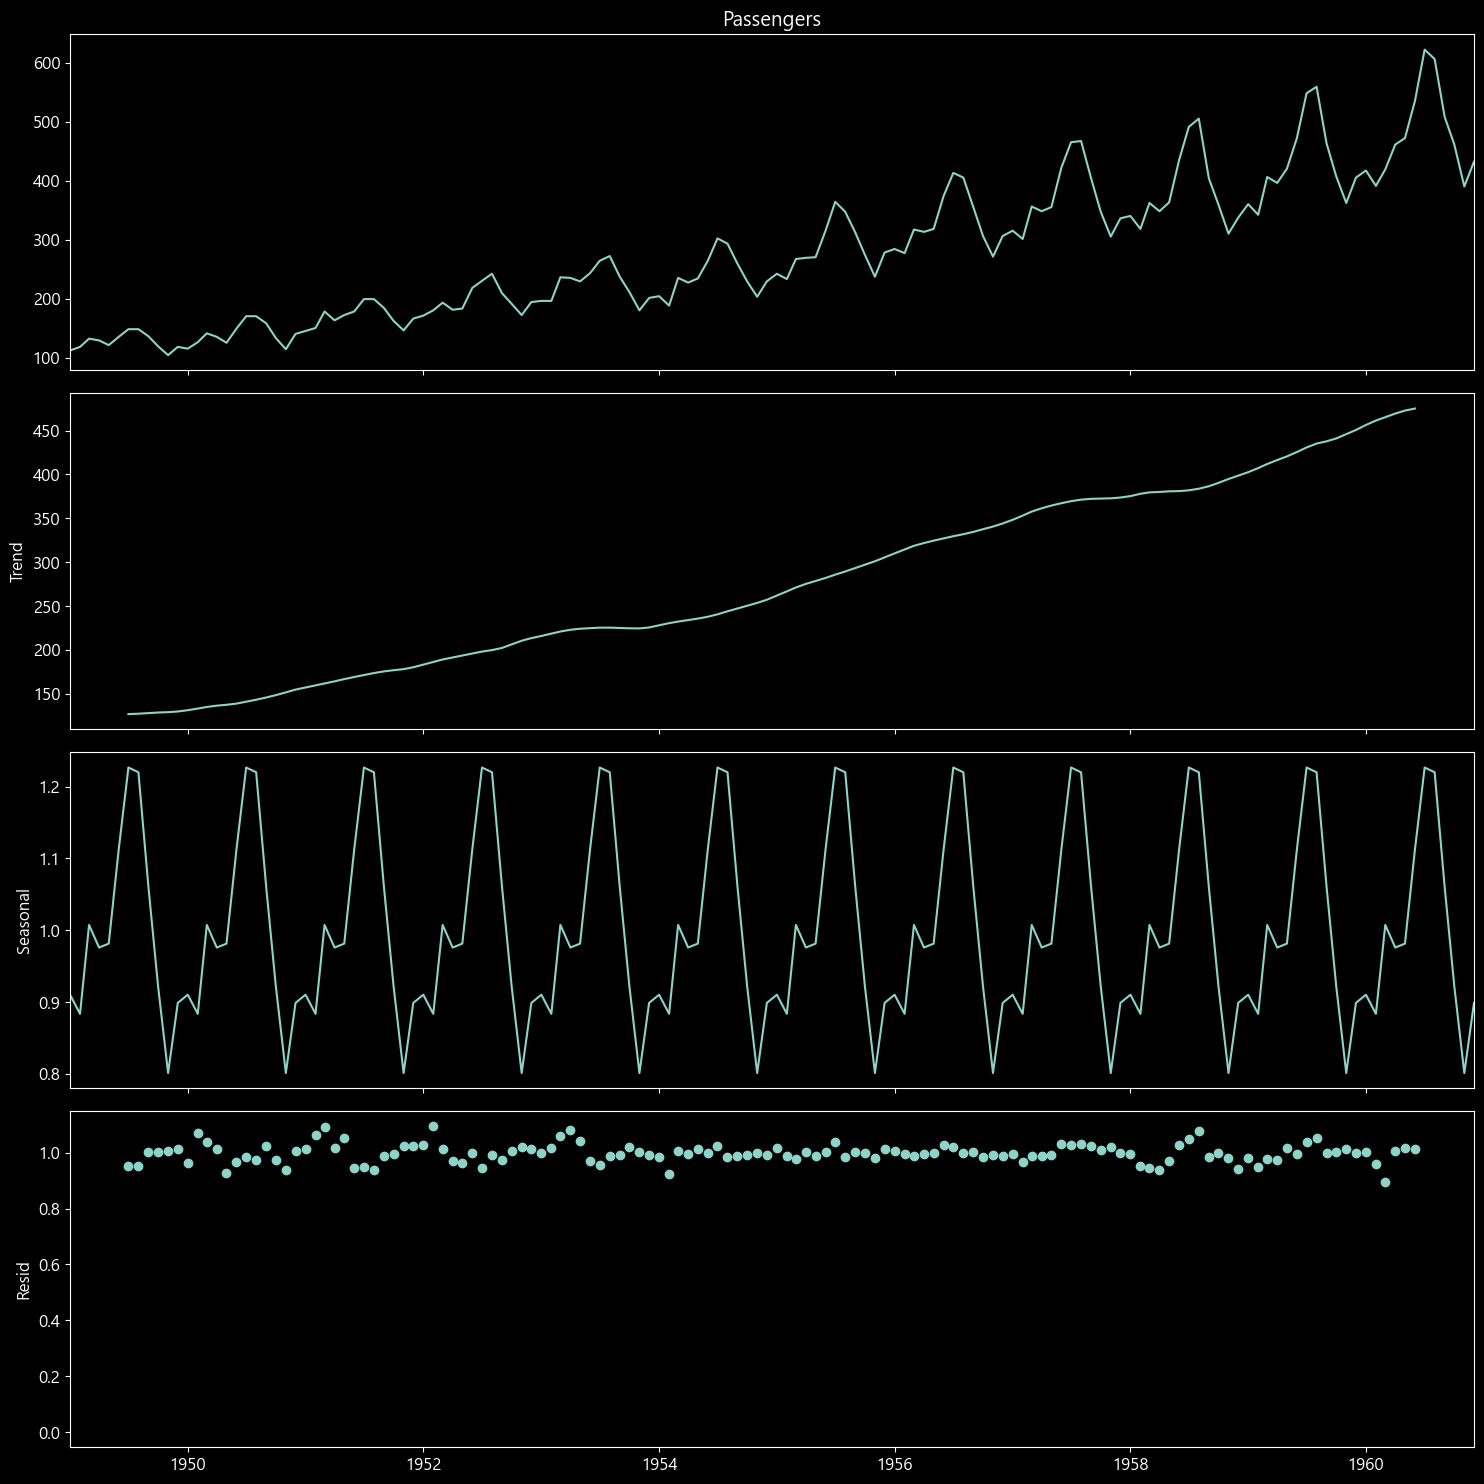

In [6]:
plt.rcParams["figure.figsize"] = (15, 15)
sd.plot()
plt.show()

#### 분석결과 시각화 (직접 구현)

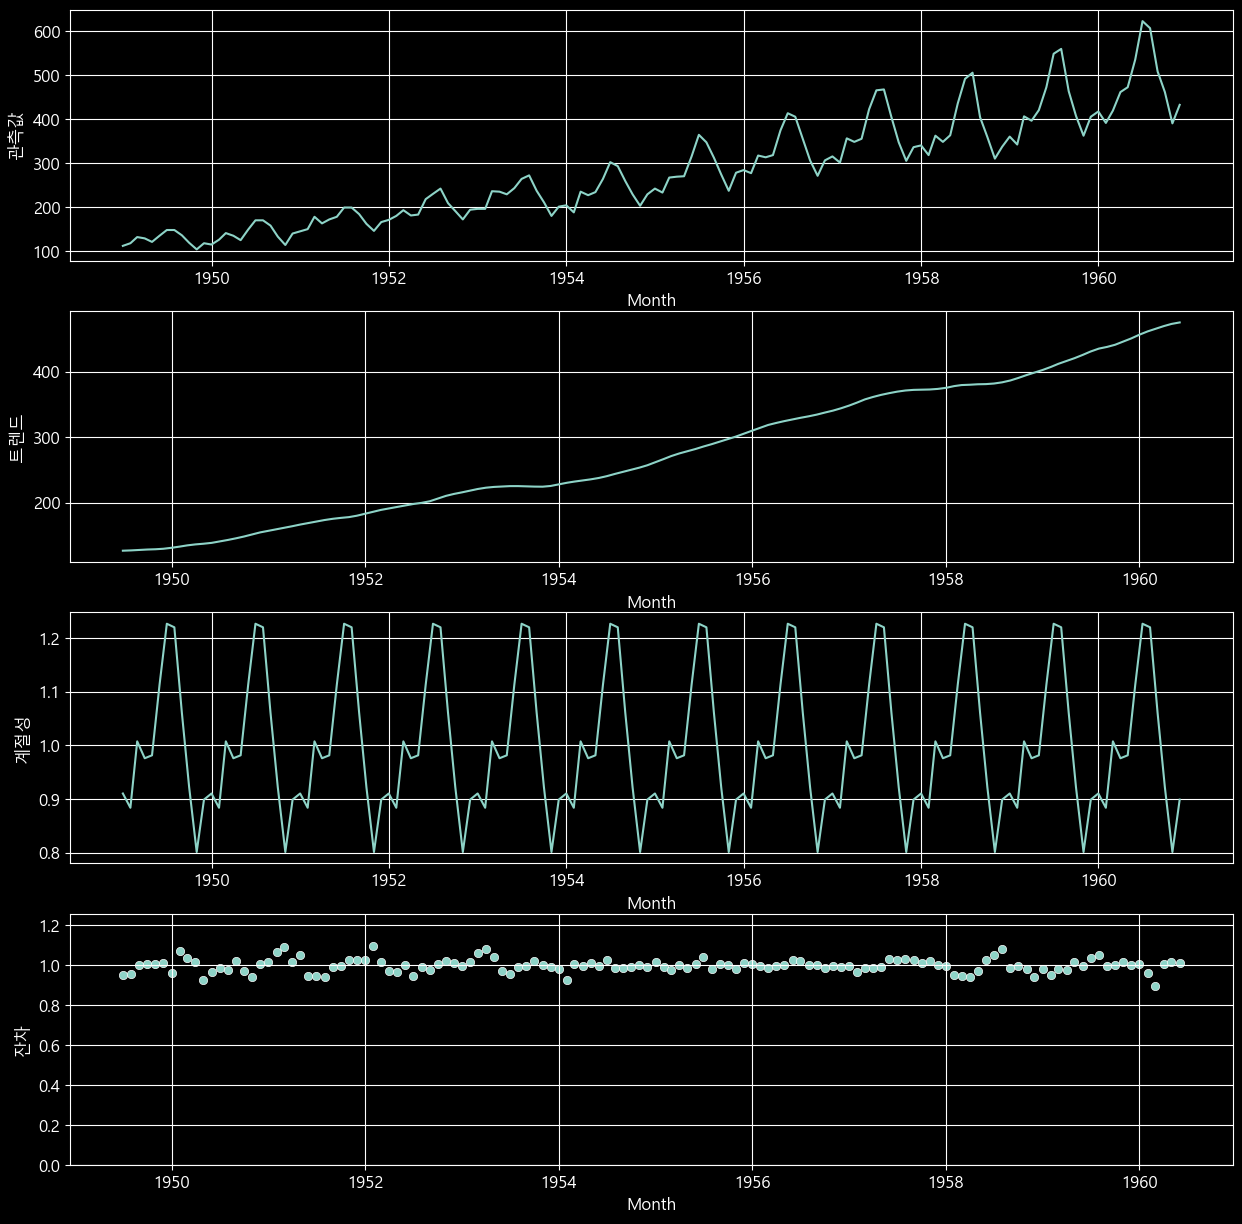

In [7]:
columns = sd_df.columns

plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots(len(columns), 1)

for i in range(len(columns)):
    if i + 1 < len(columns):
        sb.lineplot(data=sd_df, x=sd_df.index, y=columns[i], ax=ax[i])
    else:
        sb.scatterplot(data=sd_df, x=sd_df.index, y=columns[i], ax=ax[i])

        k = sd_df[columns[i]].min() * 0.85
        if k > 0:
            k = 0
        ax[i].set_ylim(k, sd_df[columns[i]].max() * 1.15)
        
    ax[i].grid()
    ax[i].set_ylabel(columns[i])

plt.show()
plt.close()

## #03. 데이터 분석

### 데이터 분할

In [8]:
# 처음부터 70% 위치 전까지 분할
train = df[:int(0.7*len(df))]
train.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
# 70% 위치부터 끝까지 분할
test = df[int(0.7*len(df)):]
test.head()

,Passengers
Month,
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404


### 모델 구축

시계열 데이터를 계절 ARIMA 모델에 맞추려고 할 때 첫 번째 목표는 측정항목을 최적화하는 $ARIMA(p,d,q)(P,D,Q)M$ 값을 찾는 것

$M$값을 고정한 상태에서 0부터 $(p,d,q)(P,D,Q)$로 주어진 값의 범위 안에서 최적의 값을 검색한다.

In [10]:
n = 2
#M = 7        # AIC: 866.450
M = 12       # AIC: 644.203
#M = 15       # AIC: 782.998

model = auto_arima(
    y=train,                # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,              # p의 시작점
    max_p=n,                # p의 최대값
    d=1,                    # 차분 횟수
    start_q=0,              # q의 시작점
    max_q=n,                # q의 최대값
    seasonal=True,          # 계절성 사용 여부
    m=M,                    # 계절성 주기
    start_P=0,              # P의 시작점
    max_P=n,                # P의 최대값
    D=1,                    # 계절성 차분 횟수
    start_Q=0,              # Q의 시작점
    max_Q=n,                # Q의 최대값
    trace=True              # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.09 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=645.940, Time=0.17 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

### 모델 학습

관측치를 모델에 적제하여 예측값을 생성하도록 한다.

In [11]:
model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

### 잔차 플롯 검토

왼쪽 상단: 잔차 오차는 평균 0을 중심으로 변동하고 균일한 분산을 갖는 것으로 보임

오른쪽 상단: 밀도 도표는 평균이 0인 정규 분포를 나타냄

왼쪽 하단: 모든 점이 빨간색 선과 완벽하게 일치해야 함. 편차가 크면 분포가 왜곡되었음을 의미합니다.

오른쪽 아래: 상관관계도(ACF 플롯이라고도 함)는 잔차 오류가 자동 상관되지 않음을 보여줌. 모든 자기상관은 모델에서 설명되지 않는 잔차 오류에 일부 패턴이 있음을 의미하기 때문에 모델에 대해 더 많은 X(예측 변수)를 찾아야 함.

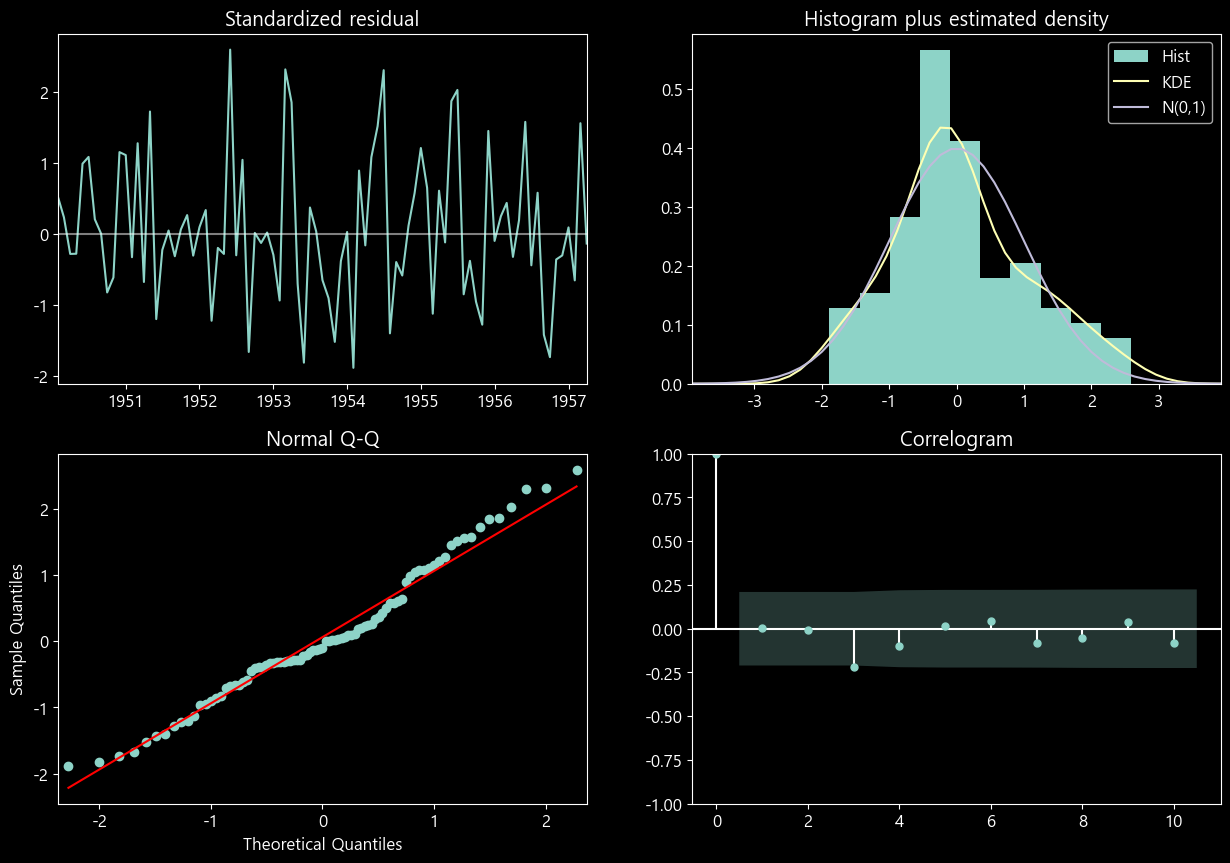

In [12]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

> 전반적으로 잘 맞는것 같다!!!

### 예상치 생성

학습결과를 토대로 주어진 `n_periods`수 만큼의 이후 데이터를 예상하여 결과를 반환한다.

In [13]:
y_predict = model.predict(n_periods=int(len(test)+24))
y_predict

1957-05-01    353.433649
1957-06-01    406.781321
1957-07-01    447.984392
1957-08-01    438.051605
1957-09-01    391.246543
                 ...    
1962-08-01    625.971455
1962-09-01    578.605788
1962-10-01    531.533999
1962-11-01    496.183471
1962-12-01    532.235663
Freq: MS, Length: 68, dtype: float64

### 관측치와 예상치 비교

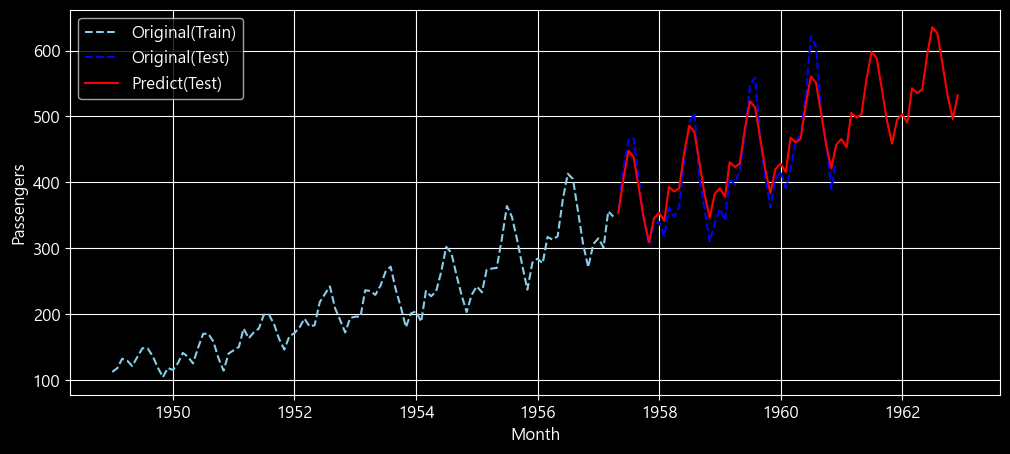

In [14]:
plt.figure(figsize=(12,5))

sb.lineplot(data=train, x=train.index, y='Passengers', label='Original(Train)', linestyle='--', color='skyblue')

sb.lineplot(data=test, x=test.index, y='Passengers', label='Original(Test)', linestyle='--', color='blue')

sb.lineplot(x=y_predict.index, y=y_predict.values, label='Predict(Test)', color='red')

plt.xlabel('Month')
plt.ylabel('Passengers')

plt.grid()
plt.show()
plt.close()